In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 👇 Update this path to where your TIFF actually is in Drive
RASTER = "/content/drive/MyDrive/Pythonprojects/Population_Density_Mapping/Content/data/ind_pop_2024_CN_100m_R2025A_v1.tif"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#install the Libraries

!pip install geopandas rasterio rasterstats folium contextily


**🧭 WHY**

**`We need tools for:`**

Vector: geopandas, shapely

Raster: rasterio

Zonal stats: rasterstats

Maps: matplotlib, folium, contextily

Tables: pandas, numpy

In [ ]:
#importing the libraries

import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import folium
import contextily as ctx
import numpy as np
import pandas as pd
from shapely.geometry import box
import os

In [ ]:
#Set paths and Folders

BASE_DIR = "/content"
DATA_DIR = f"{BASE_DIR}/data"
OUTPUT_DIR = f"{BASE_DIR}/outputs"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/maps", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/tables", exist_ok=True)

print("Folders Ready :")
print("Data directory : ",DATA_DIR )
print("Output directory : ",OUTPUT_DIR )
print("Raster : ", RASTER)


Folders Ready :
Data directory :  /content/data
Output directory :  /content/outputs
Raster :  /content/drive/MyDrive/Pythonprojects/Population_Density_Mapping/Content/data/ind_pop_2024_CN_100m_R2025A_v1.tif


In [ ]:
import os

if os.path.exists(RASTER):
    print(f"The RASTER file exists at: {RASTER}")
else:
    print(f"Error: The RASTER file does NOT exist at: {RASTER}")
    print("Please verify the path in the 'RASTER' variable or ensure the file is correctly uploaded/mounted.")

The RASTER file exists at: /content/drive/MyDrive/Pythonprojects/Population_Density_Mapping/Content/data/ind_pop_2024_CN_100m_R2025A_v1.tif


**WHY**

*Before doing anything, we must understand:*

***CRS***→ coordinate system (for projections)

***Resolution*** → pixel size (sets grid size expectations)

***Bounds*** → what area it covers

***Width/Height*** → raster dimensions

*This controls our grid size & AOI alignment.*

In [ ]:
# We need to know :
  #CRS (coordinate system)
  #Resolution
  #extent
#this controls the grid size and projections

with rasterio.open(RASTER) as src:
  print("RASTER OPENED")
  print("CRS : ", src.crs)
  print("Resolution (x,y): ", src.res)
  print("Bounds:", src.bounds)
  print("Width x Height:", src.width, "x", src.height)



RASTER OPENED
CRS :  EPSG:4326
Resolution (x,y):  (0.00083333333, 0.00083333333)
Bounds: BoundingBox(left=68.19583234055, bottom=6.755833642309984, right=97.39583222375, top=35.51166686061998)
Width x Height: 35040 x 34507


***Define AOI*** = Indirapuram, Ghaziabad

In [ ]:
# AOI: Indirapuram, Ghaziabad (approx bbox, EPSG:4326)

minx, miny = 77.3380, 28.6100  # left, bottom (lon, lat)
maxx, maxy = 77.4050, 28.6580  # right, top


aoi = gpd.GeoDataFrame(
    {"id" :[1]},
     geometry=[box(minx, miny, maxx, maxy)],
     crs = "EPSG:4326"
)

aoi

,id,geometry
0,1,"POLYGON ((77.405 28.61, 77.405 28.658, 77.338 ..."


***Clip WorldPop Raster to Indirapuram AOI***

**🧭 WHY**

*Clipping to AOI:*

Reduces raster size

Speeds up processing

Prevents Colab from crashing

Focuses analysis on the actual area of interest

In [ ]:
# We use rasterio.mask.mask() to crop the raster using AOI polygon
from rasterio.mask import mask

CLIPPED_RASTER = f"{DATA_DIR}/worldpop_indirapuram_clip.tif"

#open full raster for clipping
with rasterio.open(RASTER) as src:

  #check
  if aoi.crs != src.crs:
    aoi_raster = aoi.to_crs(src.crs)
  else:
    aoi_raster = aoi


  geoms = [aoi_raster.geometry.iloc[0]]

  #perform clipping
  out_image , out_transform = mask(src, geoms, crop=True)

  #update metadata  for clipped raster dimensions + transform
  out_meta = src.meta.copy()

  out_meta.update({
      "height": out_image.shape[1],
      "width": out_image.shape[2],
      "transform": out_transform
  })


  # Save the clipped raster to disk
  with rasterio.open(CLIPPED_RASTER, "w", **out_meta) as dest:
        dest.write(out_image)


#Confirm the file

print("clipped raster saved at : ", CLIPPED_RASTER)




clipped raster saved at :  /content/data/worldpop_indirapuram_clip.tif


***Quick Downsampled Preview (Optional, Safe)***

We want a quick visual sense of the data, without loading full resolution (which could crash).

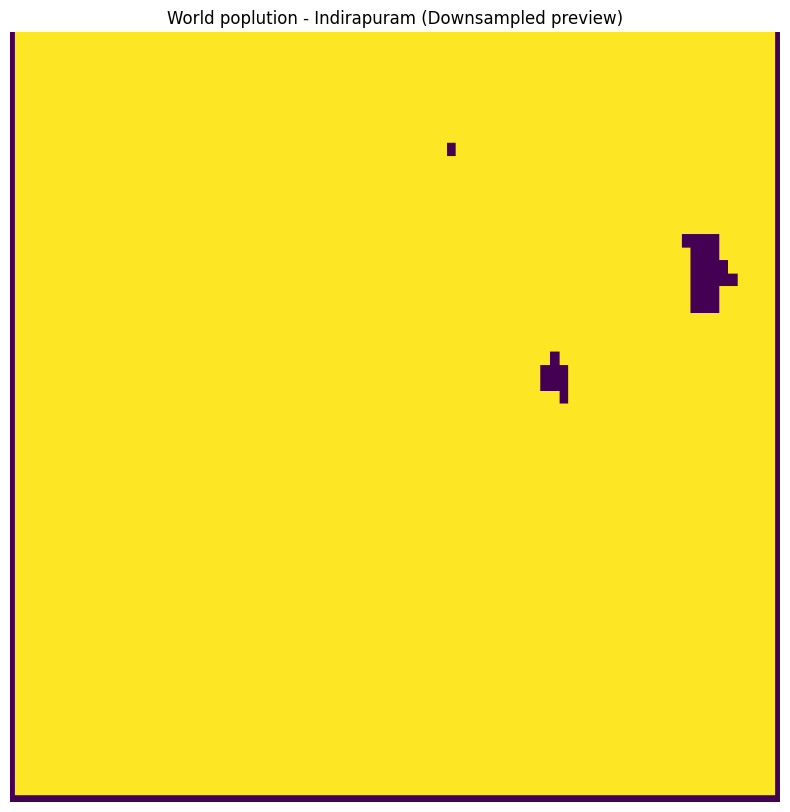

In [ ]:
from rasterio.enums import Resampling

with rasterio.open(CLIPPED_RASTER) as src:

  #define target preview size (800 * 800)
  preview_w ,preview_h = 800,800

  #Read only first band wiith downsampling process  ----- NO RAM CRASH

  data =src.read(1, out_shape = (preview_h,preview_w), resampling= Resampling.bilinear)

  #plotting it

  plt.figure(figsize=(10,10))
  plt.imshow(data , cmap = "viridis")
  plt.title("World poplution - Indirapuram (Downsampled preview)")
  plt.axis("off")
  plt.show()







***Reproject AOI to Projected CRS (for Grid)***

To create a grid in meters (e.g., 500m or 1km cells), we need a projected CRS.

We’ll use EPSG:3857 for convenience.

In [ ]:
#We use The below CRS (meter -based) for accurate grid creation

PROJECTED_CRS = "EPSG:3857"

aoi_proj = aoi.to_crs(PROJECTED_CRS)

aoi_proj

,id,geometry
0,1,"POLYGON ((8616685.185 3326100.802, 8616685.185..."


***Create Fishnet Grid over Indirapuram***

WHY

Each grid cell will be one analysis unit where we estimate population.

In [ ]:
#Lets create a function  that builds a fishnet grid within AOI bounds

def create_fishnet(aoi_gdf, cell_size_m):

    #Extracting bounding box from AOT polygon in meters
    minx, miny, maxx, maxy = aoi_gdf.total_bounds
    xs = np.arange(minx, maxx, cell_size_m)
    ys = np.arange(miny, maxy, cell_size_m)

    #build square size grid cells

    cells = []
    for x in xs:
        for y in ys:
            cells.append(box(x, y, x + cell_size_m, y + cell_size_m))

    #convert the list of shapes to geodataframe
    grid = gpd.GeoDataFrame(geometry=cells, crs=aoi_gdf.crs)
    grid_clip = gpd.overlay(grid, aoi_gdf, how="intersection")
    return grid_clip



CELL_SIZE = 500  # 500m x 500m grid cells
grid_proj = create_fishnet(aoi_proj, CELL_SIZE)

# Show grid count and preview
len(grid_proj) ,
grid_proj.head()

,id,geometry
0,1,"POLYGON ((8609726.779 3326600.802, 8609726.779..."
1,1,"POLYGON ((8609726.779 3327100.802, 8609726.779..."
2,1,"POLYGON ((8609726.779 3327600.802, 8609726.779..."
3,1,"POLYGON ((8609726.779 3328100.802, 8609726.779..."
4,1,"POLYGON ((8609726.779 3328600.802, 8609726.779..."


***Reproject Grid to Raster CRS (for Zonal Stats)***

🧭 WHY

Zonal statistics needs grid and raster in the same CRS.

In [ ]:
#open clipped raster and check it

with rasterio.open(CLIPPED_RASTER) as src_clip:
  raster_crs = src_clip.crs

#reproject the grid to match raster CRS as above ---> needed for Zonal stats
grid_raster_crs =  grid_proj.to_crs(raster_crs)

grid_raster_crs.head()




,id,geometry
0,1,"POLYGON ((77.34249 28.61394, 77.34249 28.61, 7..."
1,1,"POLYGON ((77.34249 28.61789, 77.34249 28.61394..."
2,1,"POLYGON ((77.34249 28.62183, 77.34249 28.61789..."
3,1,"POLYGON ((77.34249 28.62577, 77.34249 28.62183..."
4,1,"POLYGON ((77.34249 28.62971, 77.34249 28.62577..."


***Zonal Statistics: Population per Cell***

🧭 WHY

This is the heart of the analysis:

“How many people live inside each 500m grid cell?”

In [ ]:

#use the clipped raster for stats
RASTER_CLIP = CLIPPED_RASTER

# Perform zonal statistics using sum + mean on each grid cell
stats = zonal_stats(
    grid_raster_crs,         # grid polygons
    CLIPPED_RASTER,          # clipped Indirapuram raster
    stats=["sum", "mean"],   # population per cell
    nodata=-99999,           # WorldPop's nodata value
    masked=True              # ignore nodata pixels
)

grid_raster_crs["pop_sum"] = [s["sum"] for s in stats]
grid_raster_crs["pop_mean"] = [s["mean"] for s in stats]

grid_raster_crs[["pop_sum", "pop_mean"]].head()

,pop_sum,pop_mean
0,5341.024414,213.640977
1,4293.404785,214.670239
2,5212.207520,208.488301
3,5572.116699,222.884668
4,6129.014160,245.160566


***Compute Area & Population Density***

🧭 WHY

Density (people per km²) is a powerful indicator of how crowded an area is.

In [ ]:
#Switch Grid CRS back to the projected CRS . So as to calculate the area
grid_attr = grid_raster_crs.to_crs(PROJECTED_CRS)

grid_attr["area_km2"] = grid_attr.geometry.area / 1e6
grid_attr["pop_density_km2"] = grid_attr["pop_sum"] / grid_attr["area_km2"]

grid_attr[["pop_sum", "area_km2", "pop_density_km2"]].head()

,pop_sum,area_km2,pop_density_km2
0,5341.024414,0.25,21364.097656
1,4293.404785,0.25,17173.619141
2,5212.207520,0.25,20848.830078
3,5572.116699,0.25,22288.466797
4,6129.014160,0.25,24516.056641


Static Choropleth Map (Population)
🧭 WHY

A simple map shows patterns immediately

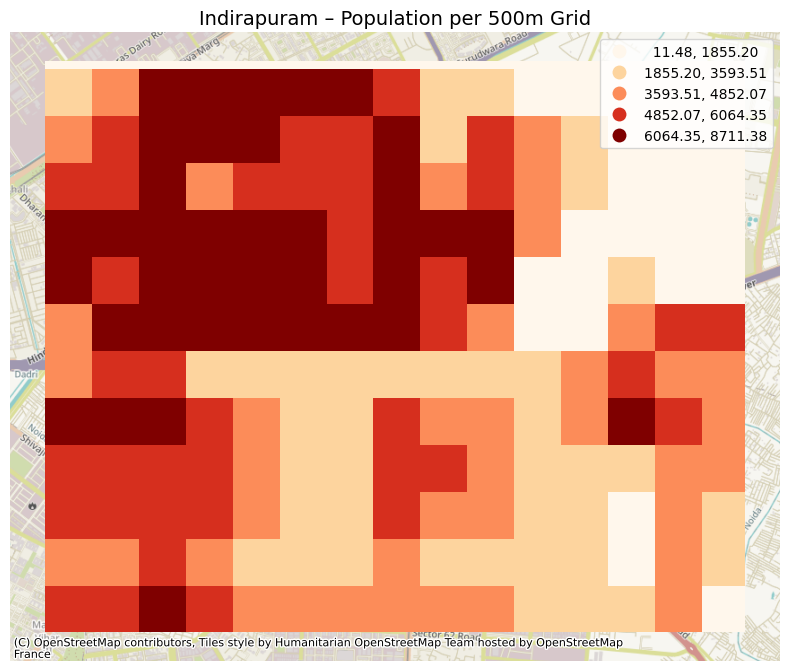

Static map saved at: /content/outputs/maps/indirapuram_pop_grid.png


In [ ]:
# Plot population per grid cell on a static map

!pip install mapclassify # Install mapclassify if not already installed

fig, ax = plt.subplots(figsize=(8, 8))

# Plot grid using quantile-based color scheme
grid_attr.plot(
    column="pop_sum",
    ax=ax,
    cmap="OrRd",
    legend=True,
    scheme="quantiles",
    k=5
)

# Add basemap (OpenStreetMap)
ctx.add_basemap(ax, crs=grid_attr.crs)

# Clean up map appearance
ax.set_axis_off()
ax.set_title("Indirapuram – Population per 500m Grid", fontsize=14)

# Save map to disk
map_path = f"{OUTPUT_DIR}/maps/indirapuram_pop_grid.png"
plt.tight_layout()
plt.savefig(map_path, dpi=300)
plt.show()

print("Static map saved at:", map_path)

**ANALYSIS OF ABOVE MAP (Population per 500m Grid Cell)**

Map shows the total number of people living in each grid cell.


Population = absolute people count

**Analysis of Map  — Population per 500m Grid (Absolute Population)**

***✔ What This Map Shows***

The total number of people living inside each grid cell, regardless of area.

Color Meaning:

Dark red = 6,000–8,700 people

Medium red = 4,800–6,000

Orange = 3,600–4,800

Yellow/cream = ~2,000 or less

***✔ Key Observations***

1️⃣ Central & North-Western Indirapuram have the highest populations
These areas hold 7,000–8,700 people per 500m block, showing:

High occupancy per building

Dense apartment clusters

Popular residential pockets

2️⃣ Some grid cells with medium population still show high density
This happens when:

A cell has few buildings, but each is very crowded

Lots of mid-rise apartments packed into small areas

3️⃣ Sparse population cells are aligned with open spaces
The lightest regions match:

Parks

Playgrounds

Empty lots

Commercial complexes

Main roads




Interactive Map (Optional))

In [ ]:
# Convert grid back to lat/lon for web display
grid_wgs84 = grid_attr.to_crs(epsg=4326)
center = grid_wgs84.geometry.unary_union.centroid

m = folium.Map(location=[center.y, center.x], zoom_start=14)

folium.GeoJson(
    grid_wgs84,
    tooltip=folium.GeoJsonTooltip(
        fields=["pop_sum", "pop_density_km2"],
        aliases=["Population:", "Density (per km²):"],
        localize=True
    )
).add_to(m)

m

/tmp/ipython-input-2872926093.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center = grid_wgs84.geometry.unary_union.centroid


***This map highlights areas that are crowded, not just high population.***

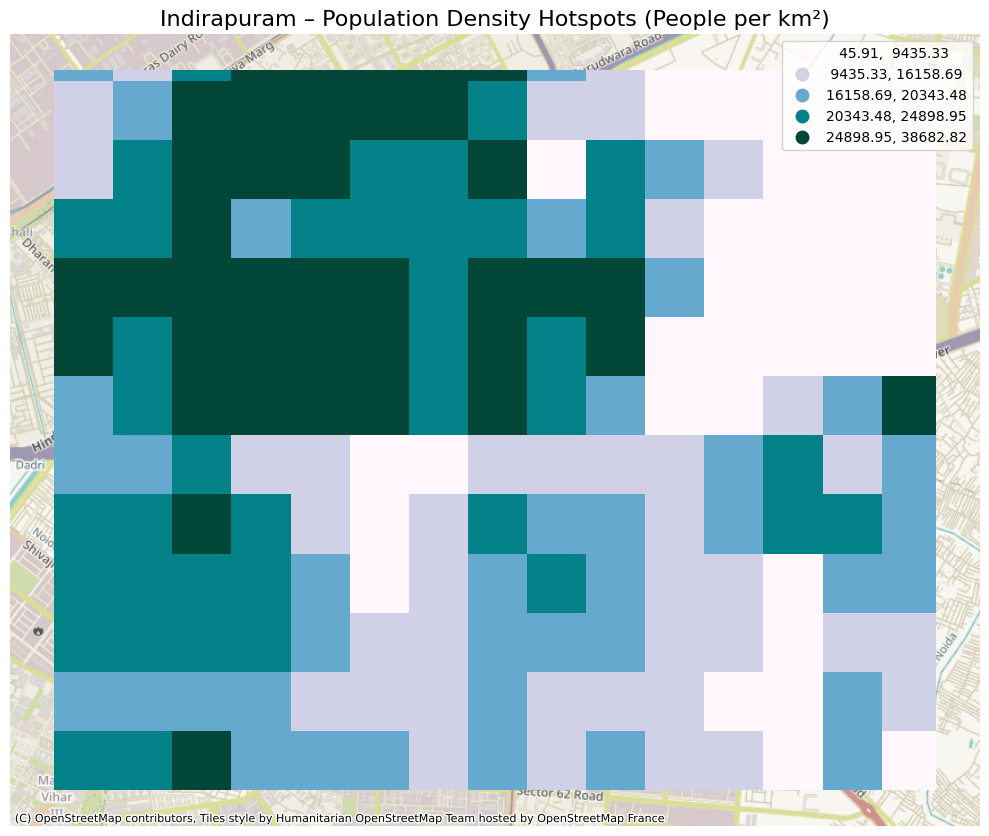

📌 Density Hotspot Map saved at: /content/outputs/maps/indirapuram_density_hotspot.png


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

grid_attr.plot(
    column="pop_density_km2",
    ax=ax,
    cmap="PuBuGn",            # blue-green density palette
    scheme="quantiles",
    k=5,
    legend=True
)

ctx.add_basemap(ax, crs=grid_attr.crs)
ax.set_title("Indirapuram – Population Density Hotspots (People per km²)", fontsize=16)
ax.set_axis_off()

density_map_path = f"{OUTPUT_DIR}/maps/indirapuram_density_hotspot.png"
plt.tight_layout()
plt.savefig(density_map_path, dpi=300)
plt.show()

print("📌 Density Hotspot Map saved at:", density_map_path)

Analysis of above MAP (Population Density Hotspots (People per km²)

Map shows how crowded each grid cell is

Density = pressure on area (crowding)

***✔ What the Map Shows***

This map highlights how tightly people are packed into each 500m cell.

Color Meaning:

*Dark teal *= extremely high density (20,000–38,000 people per km²)

*Medium teal* = 16,000–20,000 people/km²

*Light blue* = lower density

*White/light areas* = low or no residential population



***✔ Key Observations***

1️⃣ Northern Indirapuram is the densest zone
The top-left to center-left region shows continuous dark teal, indicating:

Many multi-storey apartment complexes

Very little open space

High occupancy residential blocks

These are typically localities like:

Gyan Khand parts

Shipra Suncity dense pockets


2️⃣ Some central pockets are surprisingly sparse
White/light patches in the middle indicate:

Parks

Open grounds

Commercial buildings

Road intersections

Under-construction or institutional areas



3️⃣ Density drops toward the southern edge
South/south-east zones have fewer dark colors:

More open plots

Wider roads

Lower-rise housing



***Summary Table & Export***

In [ ]:
# We calculate basic descriptive statistics for population per grid cell
summary = grid_attr["pop_sum"].describe()
print("Summary of population per grid:\n", summary)

# We extract the top 10 most populated grid cells for hotspot analysis
top10 = grid_attr.nlargest(10, "pop_sum")[["pop_sum", "pop_density_km2"]]
print("\nTop 10 most populated cells:\n", top10)

# We define a path for saving the CSV inside the outputs/tables folder
# Note: we use OUT (defined earlier as /content/outputs), not OUTPUT_DIR
csv_path = f"{OUTPUT_DIR}/tables/indirapuram_population_grid_stats.csv"

# We drop the geometry column because CSV can't store polygon geometry properly
grid_attr.drop(columns="geometry").to_csv(csv_path, index=False)

# We print the location of the saved CSV so you can find it in Colab or download it
print("\n📄 CSV saved at:", csv_path)

Summary of population per grid:
 count     195.000000
mean     4075.566851
std      2166.372182
min        11.478696
25%      2340.778320
50%      4240.894043
75%      5634.140869
max      8711.384766
Name: pop_sum, dtype: float64

Top 10 most populated cells:
         pop_sum  pop_density_km2
60  8711.384766     34845.539062
63  8470.797852     33883.191406
59  8281.330078     33125.320312
33  8274.172852     33096.691406
58  8160.194824     32640.779297
32  7931.390625     31725.562500
62  7691.950195     30767.800781
99  7601.227051     30404.908203
49  7554.867676     30219.470703
37  7494.212402     29976.849609

📄 CSV saved at: /content/outputs/tables/indirapuram_population_grid_stats.csv


# ***ANALYSIS ***


**Study area **(Indirapuram, Ghaziabad) was divided into 195 grid cells, each measuring 500m × 500m.

For each grid cell, total population was extracted from the WorldPop 2025 dataset.


***📌 Key Statistics (What They Tell Us)***

| Metric                   | Meaning                     | Interpretation                                            |
| ------------------------ | --------------------------- | --------------------------------------------------------- |
| **count = 195**          | Number of grid cells        | Indirapuram is covered by 195 analysis units              |
| **mean = 4,075 people**  | Average population per grid | A typical 500m cell contains ~4,000 people                |
| **std = 2,166**          | Variation in population     | High density variation; some cells are far more populated |
| **min = 11 people**      | Least populated cell        | Likely parks, open spaces, or non-residential areas       |
| **25% = 2,340 people**   | Lower-density quartile      | 25% of cells have fewer than ~2,300 people                |
| **50% (median) = 4,240** | Middle population           | Half the area has fewer than ~4,200 people                |
| **75% = 5,634**          | High-density quartile       | 25% of the area exceeds ~5,600 people per cell            |
| **max = 8,711 people**   | Highest-density cell        | Densest cluster in Indirapuram, extremely urbanized       |



***🎯 What This Means in Simple Words***

Most of Indirapuram is moderately to highly populated, with 4,000–5,500 people per 500m block.

There is strong density contrast:
some cells have only a few dozen people (parks, roads),
while dense apartment clusters host 7,000–8,700 people.

This confirms Indirapuram is a high-density residential node of NCR.


🔥 Top 10 Most Populated Cells (Hotspots)

The following grid cells show extremely high population values:

| Grid ID | Population | Density (per km²) |
| ------- | ---------- | ----------------- |
| 60      | 8,711      | 34,845            |
| 63      | 8,470      | 33,883            |
| 59      | 8,281      | 33,125            |
| 33      | 8,274      | 33,097            |
| 58      | 8,160      | 32,640            |
| 32      | 7,931      | 31,725            |
| 62      | 7,691      | 30,767            |
| 99      | 7,601      | 30,404            |
| 49      | 7,554      | 30,219            |
| 37      | 7,494      | 29,976            |




🌆 Interpretation of Hotspots

These cells represent the densest residential blocks in Indirapuram:

High-rise apartment clusters

Compact multi-storey housing

Areas with minimum open space

Classic NCR high-density urban morphology

**Density values over 30,000 people per km² are extremely high and comparable to the densest parts of:**

Mumbai suburbs

South Delhi colonies

Gurugram's apartment belts


# Urban Planning Meaning

This analysis highlights:

Infrastructure demand zones

High-service-pressure cells (water, electricity, waste)

Potential congestion hotspots

Areas suitable for targeted mobility planning

Zones where social amenities may need reinforcement

# ***Combined Insight From Both Maps Together***

By comparing Population Hotspots + Density Hotspots, you get deeper understanding:

🔍 If a cell is:

High population + High density → Severe pressure zone

High population + Moderate density → Balanced apartment zones

Low population + High density → Few buildings but extremely crowded

Low population + Low density → Open areas, parks, commercial roads


# **`ANALYSIS About Indirapuram’s Urban Structure`**

What This Means About Indirapuram’s Urban Structure
✔ Indirapuram is a classic NCR high-density township

Most population clusters are above 4,000–6,000 people per 500m cell.

✔ Residential blocks are extremely compact

High population AND high density in multiple cells

Very little open space in some mid-northern parts

✔ Urban planning pressure is high in hotspot cells:

Water supply demand

Waste generation

Mobility congestion

Public safety load

Green space deficits

✔ Southern and central pockets show opportunity zones

Could support new infrastructure

More open space

Lower population footprint

# ***FINAL SUMMARY ANALYSIS***


“In Indirapuram, population per 500m grid ranges from as low as 11 people to as high as 8,700 people per cell. When we convert this to density, the hotspot regions cross 30,000 to 38,000 people per km², indicating extremely compact urban settlements.

The densest regions appear in the north-west and central sectors — areas dominated by multi-storey apartments. Meanwhile, the lighter zones reveal parks, commercial pockets, and open spaces.

Together, these maps help planners identify where services and infrastructure need to be strengthened, where population pressure is highest, and which areas can support future growth.”